In [ ]:
#set the colab to access the google drive
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("drive/MyDrive/Colab Notebooks/CoV_Encoder")

Mounted at /content/drive/


In [ ]:
#import package
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate

%matplotlib inline

In [ ]:
# Read a file and split into train,validation,test sets

data_path = 'data/S-HA_Abs_v6_binary.xlsx'
raw_df = pd.read_excel(data_path)
raw_df=raw_df[raw_df[['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA']].notnull().all(1)]
cleaned_df = raw_df[['Name','cluster','Antigen','Resources','CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA','VH Genbank ID','VL Genbank ID']].copy()

#deduplication
cleaned_df = cleaned_df.drop_duplicates(subset=['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA'])

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# # Over sampling for training set HA Abs
# S_train_df = train_df[train_df.Antigen == 'Spike']
# S_num = len(S_train_df)
# HA_train_df = train_df[train_df.Antigen == 'HA']
# print(HA_train_df)
# HA_train_df=HA_train_df.sample(S_num, replace=True) 
# print(HA_train_df)
# train_df = pd.concat([S_train_df,HA_train_df])

print(len(train_df))
print(len(val_df))
print(len(test_df))


4441
1111
1388


In [ ]:
# save train_df, val_df, test_df
train_df['dataset']='train set'
val_df['dataset']='val set'
test_df['dataset']='test set'
dataset_df = df=pd.concat([train_df,val_df,test_df])
dataset_df.to_csv('result/Spike_Flu_dataset.csv')


# Data processing

In [ ]:

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
def integer_encoding(data,CDR):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rests  are categorized as 21.
  """
  
  encode_list = []
  for row in data[CDR].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 21))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [ ]:
def encode_six_CDR(data,max_length = 30):
  """
  - Encodes code sequence to integer values.
  - add post-padding
  """
  cdr_list = ['CDRH1_AA','CDRL1_AA','CDRH2_AA','CDRL2_AA','CDRH3_AA','CDRL3_AA']
  encoded_cdr_list=[]
  for cdr in cdr_list:
    encoded_cdr=integer_encoding(data,cdr)
    pad_cdr=pad_sequences(encoded_cdr,maxlen=max_length, padding='post', truncating='post')
    encoded_cdr_list.append(pad_cdr)
  return encoded_cdr_list

In [ ]:
[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6]=encode_six_CDR(train_df)
[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6]=encode_six_CDR(val_df)
[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6]=encode_six_CDR(test_df)
print(train_x1.shape, val_x1.shape, test_x1.shape)
print(test_x1[0])

(4441, 30) (1111, 30) (1388, 30)
[ 6  5 17  5 16 17 20  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [ ]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train = le.fit_transform(train_df['Antigen'])
y_val = le.transform(val_df['Antigen'])
y_test = le.transform(test_df['Antigen'])

print(y_train.shape, y_val.shape, y_test.shape)
print('Total classes: ', len(le.classes_))

(4441,) (1111,) (1388,)
Total classes:  2


# Basic statistics

In [ ]:
def Count_Abs_bycls(train, test, val):
  """
  Prints # Antibody number in different classes in data sets.
  """
  train_count = train['Antigen'].value_counts()
  val_count = val['Antigen'].value_counts()
  test_count = test['Antigen'].value_counts()

  print('Number of Abs in different classes in Train:\n',train_count,'\n')
  print('Number of Abs in different classes in Val:\n',val_count,'\n')
  print('Number of Abs in different classes in Test:\n',test_count,'\n')
  

Count_Abs_bycls(train_df,test_df,val_df)

Number of Abs in different classes in Train:
 Spike    3059
HA       1382
Name: Antigen, dtype: int64 

Number of Abs in different classes in Val:
 Spike    755
HA       356
Name: Antigen, dtype: int64 

Number of Abs in different classes in Test:
 Spike    922
HA       466
Name: Antigen, dtype: int64 



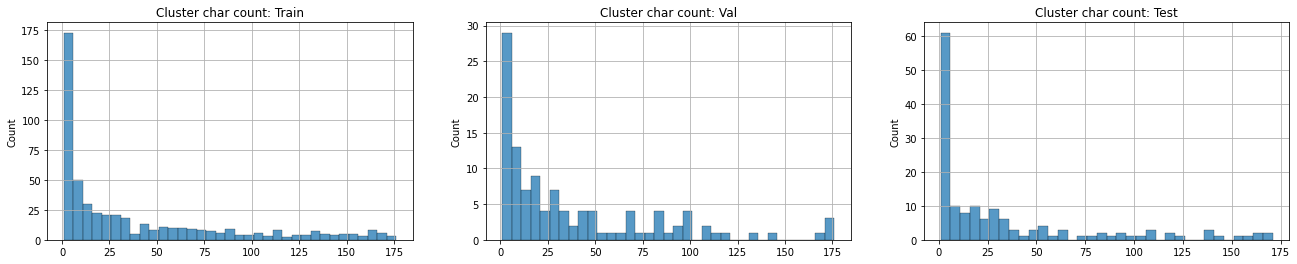

In [ ]:
def plot_cluster_count(df, data_name):
  sns.histplot(df['cluster'].values,binwidth=5)
  plt.title(f'Cluster char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_cluster_count(train_df, 'Train')

plt.subplot(1, 3, 2)
plot_cluster_count(val_df, 'Val')

plt.subplot(1, 3, 3)
plot_cluster_count(test_df, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

# Transformer building block

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)  

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
class Defined_MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(Defined_MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = Defined_MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = Defined_MultiHeadAttention(d_model, num_heads)
    self.mha2 = Defined_MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    

In [ ]:
# transformer = Transformer(
#     num_layers=num_layers,
#     d_model=d_model,
#     num_heads=num_heads,
#     dff=dff,
#     input_vocab_size=21,
#     target_vocab_size=2,
#     pe_input=max_length,
#     pe_target=max_length,
#     rate=dropout_rate)

In [ ]:
# checkpoint_path = "./checkpoints/train"

# ckpt = tf.train.Checkpoint(transformer=transformer,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print('Latest checkpoint restored!!')

In [ ]:

def create_mlp(dim=30):
	# define our MLP network
	model = Sequential()
	model.add(Dense(dim, activation="relu"))
	model.add(Dense(dim, activation="relu"))

	return model

#Building transformer encoder+ MLP

In [ ]:
def build_t_encoder(
    num_layers,
    d_model,
    num_heads,
    dff,
    input_vocab_size,
    maximum_position_encoding,
    training=True,
    rate=0.1
):
    inputs = keras.layers.Input(shape=(30,))
    x=inputs
    enc_padding_mask = create_padding_mask(inputs)
    encoder = Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, maximum_position_encoding, rate)
    x = encoder(x,training,enc_padding_mask)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    t_encoder = keras.Model(inputs, x)
    # for dim in mlp_units:
    #     x = layers.Dense(dim, activation="relu")(x)
    #     x = layers.Dropout(rate)(x)
    # outputs = layers.Dense(n_classes, activation="softmax")(x)
    return t_encoder

## CDRH3 model

In [ ]:
def CDRH3_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    x = encoder1
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(input1,outputs)

In [ ]:
CDRH3_model = CDRH3_model(mlp_units=[512,128,64],n_classes=1)
CDRH3_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRH3_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRH3_history=CDRH3_model.fit(
    train_x5, y_train,
    epochs=100, batch_size=256,
    validation_data=(val_x5, y_val),
    callbacks=callbacks,
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 model (Functional)          (None, 30)                1325824   
                                                                 
 dense_24 (Dense)            (None, 512)               15872     
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256

In [ ]:

plt.style.use('ggplot')

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


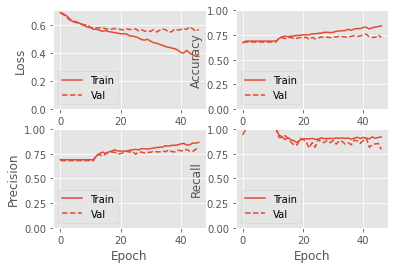

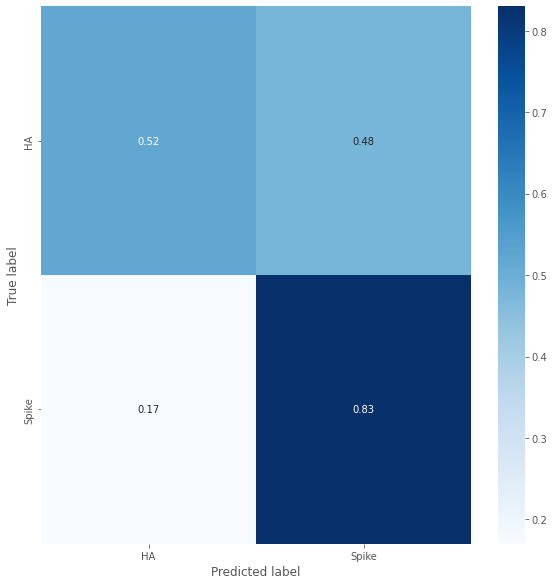

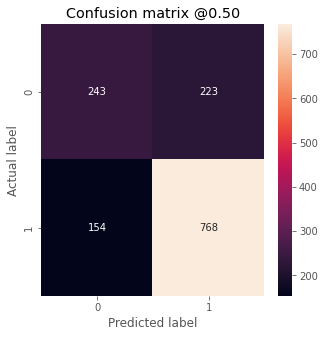

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRH3_history)
y_pred=CDRH3_model.predict(test_x5)

con_mat = confusion_matrix(y_test, y_pred > 0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDRL3 model

In [ ]:
def CDRL3_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    x = encoder1
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(input1,outputs)

In [ ]:
CDRL3_model = CDRL3_model(mlp_units=[512,128,64],n_classes=1)
CDRL3_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRL3_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRL3_history=CDRL3_model.fit(
    train_x6, y_train,
    epochs=100, batch_size=256,
    validation_data=(val_x6, y_val),
    callbacks=callbacks,
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 model_2 (Functional)        (None, 30)                1325824   
                                                                 
 dense_52 (Dense)            (None, 512)               15872     
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               65664     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_54 (Dense)            (None, 64)                8256

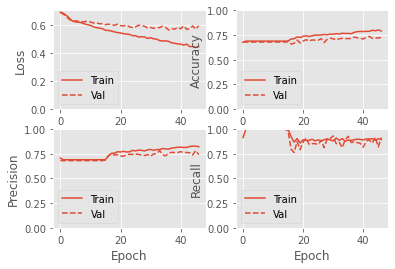

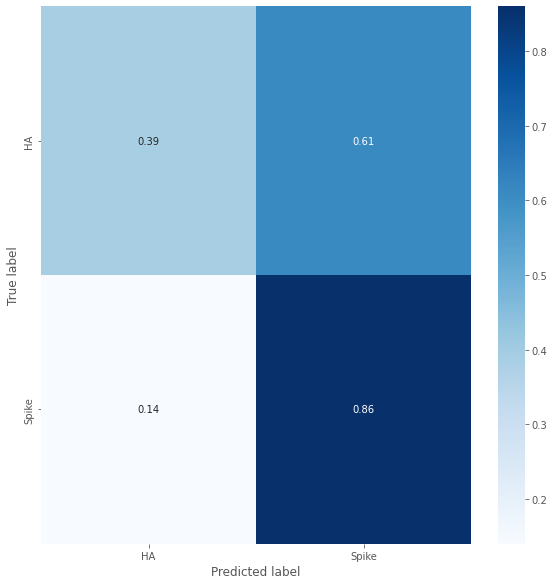

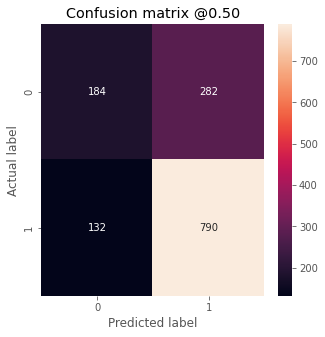

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRL3_history)
y_pred=CDRL3_model.predict(test_x6)

con_mat = confusion_matrix(y_test, y_pred > 0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDRHL3 model

In [ ]:
def CDRHL3_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    
    
    x = Concatenate()([encoder1, encoder2])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2],outputs)

In [ ]:
CDRHL3_model = CDRHL3_model(mlp_units=[512,128,64],n_classes=1)
CDRHL3_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRHL3_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRHL3_history=CDRHL3_model.fit(
    [train_x5,train_x6], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x5,val_x6], y_val),
    callbacks=callbacks,
)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 model_4 (Functional)           (None, 30)           1325824     ['input_5[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 30)           1325824     ['input_6[0][0]']                
                                                                                            

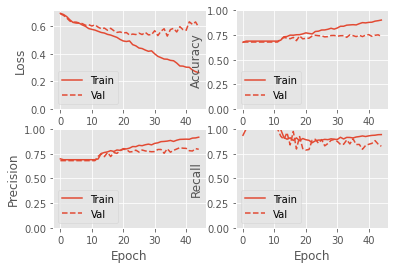

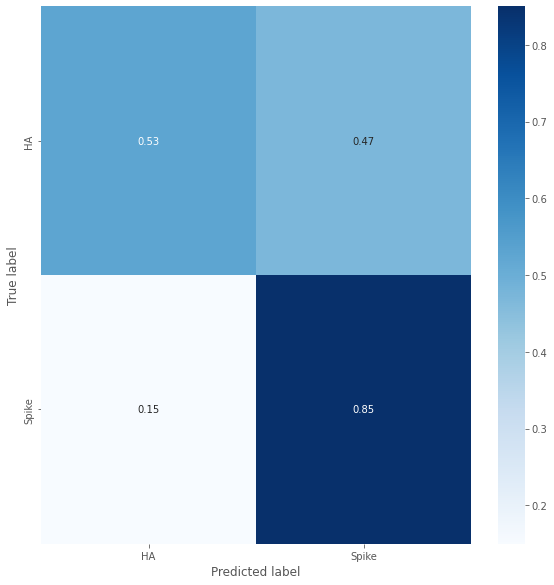

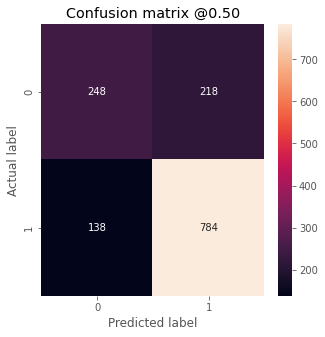

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRHL3_history)
y_pred=CDRHL3_model.predict([test_x5,test_x6])

con_mat = confusion_matrix(y_test, y_pred > 0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

Test by Reincke_RBD

In [ ]:
data_path = 'data/Reincke_RBD_cdr3.xlsx'
Reincke_df = pd.read_excel(data_path)
Reincke_x5_encode = integer_encoding(Reincke_df,'CDRH3_AA')
Reincke_x5 = pad_sequences(Reincke_x5_encode, maxlen=30, padding='post', truncating='post')
Reincke_x6_encode = integer_encoding(Reincke_df,'CDRL3_AA')
Reincke_x6 = pad_sequences(Reincke_x6_encode, maxlen=30, padding='post', truncating='post')

Reincke_test=le.transform(Reincke_df['Protein + Epitope'])


print(Reincke_x5.shape)
print(Reincke_x6.shape)
print(Reincke_test.shape)

(289, 30)
(289, 30)
(289,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


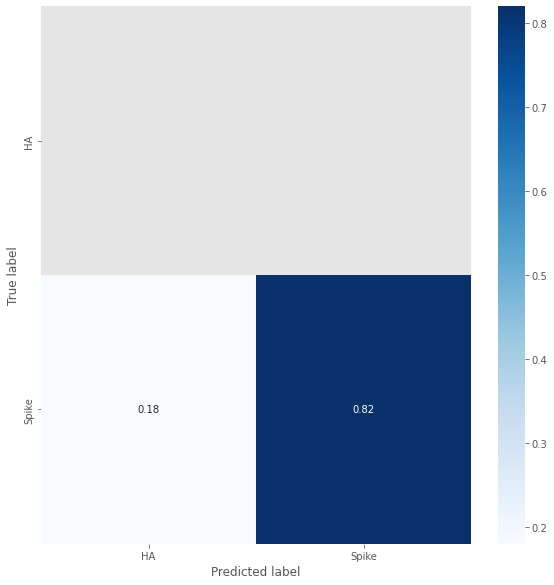

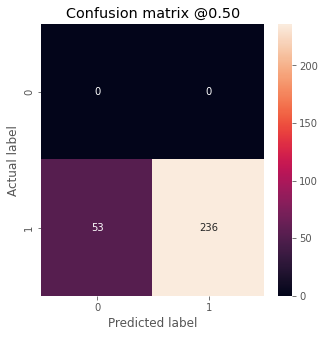

In [ ]:
y_pred=CDRHL3_model.predict([Reincke_x5,Reincke_x6])

con_mat = confusion_matrix(Reincke_test, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=Reincke_test, predictions=y_pred)

In [ ]:
Reincke_test_score = CDRHL3_model.evaluate([Reincke_x5,Reincke_x6], Reincke_test, batch_size=256, verbose=1)
print(Reincke_test_score)

2/2 [==============================] - 0s 30ms/step - loss: 0.3428 - tp: 241.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 48.0000 - accuracy: 0.8339 - precision: 1.0000 - recall: 0.8339 - auc: 0.0000e+00 - prc: 1.0000
[0.34278300404548645, 241.0, 0.0, 0.0, 48.0, 0.8339100480079651, 1.0, 0.8339100480079651, 0.0, 0.9999999403953552]


## CDRH12 model

In [ ]:
def CDRH12_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    
    
    x = Concatenate()([encoder1, encoder2])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2],outputs)

In [ ]:
CDRH12_model = CDRH12_model(mlp_units=[512,128,64],n_classes=1)
CDRH12_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRH12_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRH12_history=CDRH12_model.fit(
    [train_x1,train_x3], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x1,val_x3], y_val),
    callbacks=callbacks,
)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 model_7 (Functional)           (None, 30)           1325824     ['input_9[0][0]']                
                                                                                                  
 model_8 (Functional)           (None, 30)           1325824     ['input_10[0][0]']               
                                                                                            

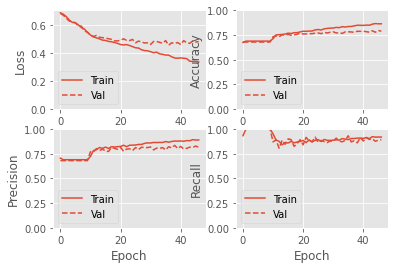

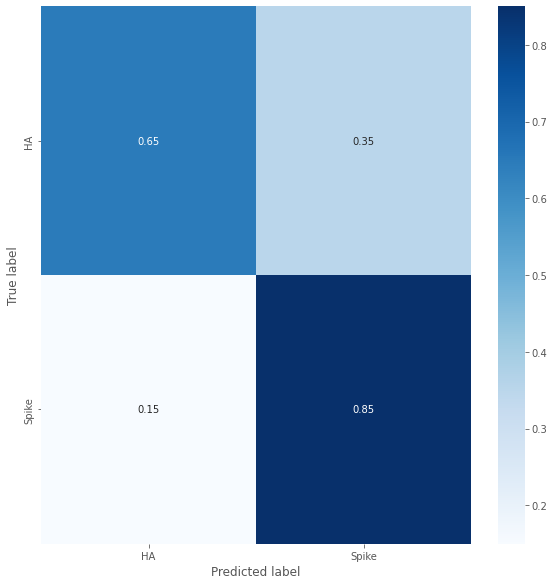

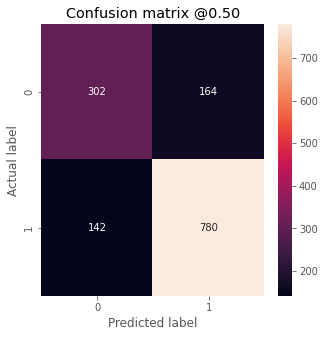

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRH12_history)
y_pred=CDRH12_model.predict([test_x1,test_x3])

con_mat = confusion_matrix(y_test, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDRL12 model

In [ ]:
def CDRL12_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
   
    x = Concatenate()([encoder1, encoder2])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2],outputs)

In [ ]:
CDRL12_model = CDRL12_model(mlp_units=[512,128,64],n_classes=1)
CDRL12_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRL12_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRL12_history=CDRL12_model.fit(
    [train_x2,train_x4], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x2,val_x4], y_val),
    callbacks=callbacks,
)


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 model_10 (Functional)          (None, 30)           1325824     ['input_13[0][0]']               
                                                                                                  
 model_11 (Functional)          (None, 30)           1325824     ['input_14[0][0]']               
                                                                                           

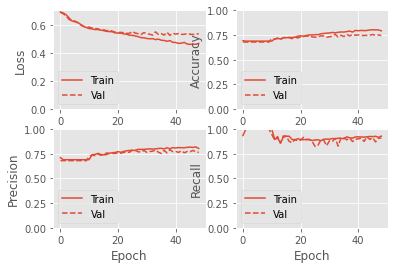

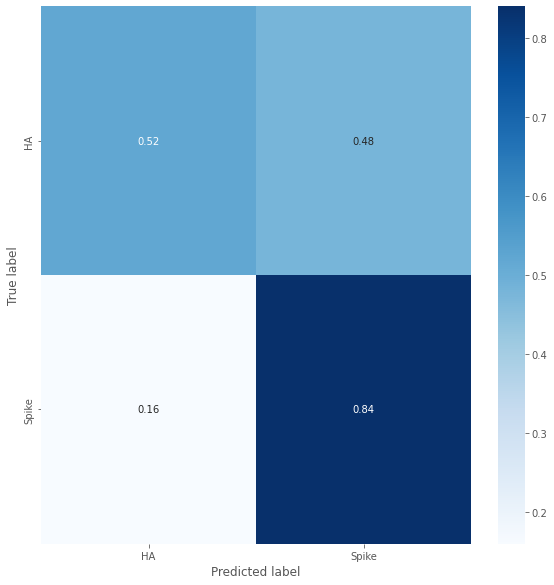

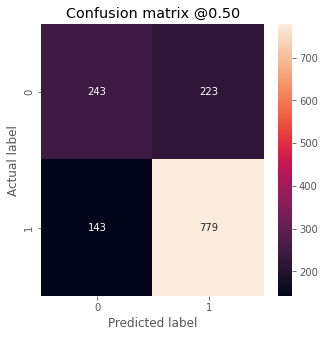

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRL12_history)
y_pred=CDRL12_model.predict([test_x2,test_x4])
con_mat = confusion_matrix(y_test, y_pred > 0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDRH123 model

In [ ]:
def CDRH123_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))
    input3=keras.layers.Input(shape=(30,))
    

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    encoder3=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input3)
    
    x = Concatenate()([encoder1, encoder2,encoder3])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2,input3],outputs)

In [ ]:
CDRH123_model = CDRH123_model(mlp_units=[512,128,64],n_classes=1)
CDRH123_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRH123_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRH123_history=CDRH123_model.fit(
    [train_x1,train_x3,train_x5], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x1,val_x3,val_x5], y_val),
    callbacks=callbacks,
)


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 model_13 (Functional)          (None, 30)           1325824     ['input_17[0][0]']               
                                                                                           

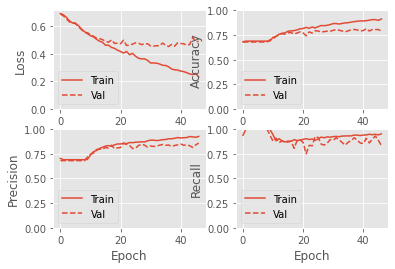

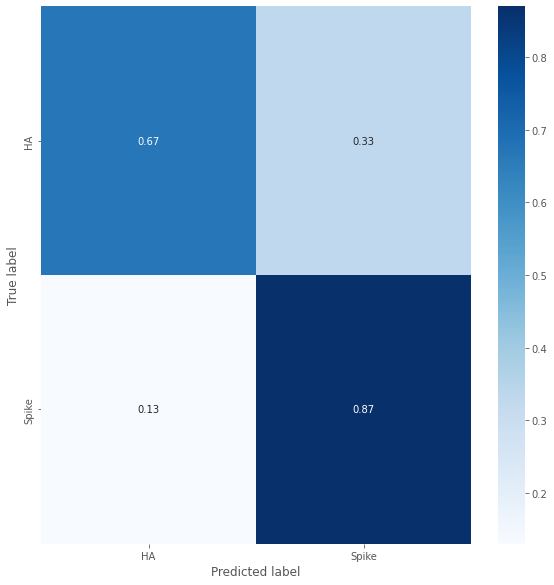

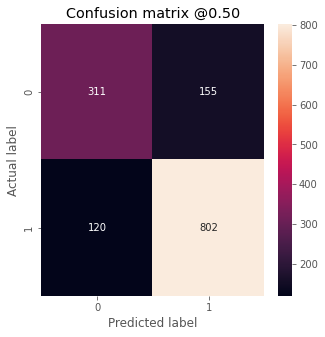

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRH123_history)
y_pred=CDRH123_model.predict([test_x1,test_x3,test_x5])

con_mat = confusion_matrix(y_test, y_pred > 0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDRL123 model

In [ ]:
def CDRL123_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))
    input3=keras.layers.Input(shape=(30,))
    

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    encoder3=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input3)
    
    x = Concatenate()([encoder1, encoder2,encoder3])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2,input3],outputs)

In [ ]:
CDRL123_model = CDRL123_model(mlp_units=[512,128,64],n_classes=1)
CDRL123_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDRL123_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDRL123_history=CDRL123_model.fit(
    [train_x2,train_x4,train_x6], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x2,val_x4,val_x6], y_val),
    callbacks=callbacks,
)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 model_17 (Functional)          (None, 30)           1325824     ['input_23[0][0]']               
                                                                                           

In [ ]:

plt.style.use('ggplot')

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDRL123_history)
y_pred=CDRL123_model.predict([test_x2,test_x4,test_x6])

con_mat = confusion_matrix(y_test, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=y_test, predictions=y_pred)

## CDR model

In [103]:
def CDR_model(mlp_units,n_classes,rate=0.1,max_length=30):
    input1=keras.layers.Input(shape=(30,))
    input2=keras.layers.Input(shape=(30,))
    input3=keras.layers.Input(shape=(30,))
    input4=keras.layers.Input(shape=(30,))
    input5=keras.layers.Input(shape=(30,))
    input6=keras.layers.Input(shape=(30,))

    encoder1=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input1)
    encoder2=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input2)
    encoder3=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input3)
    encoder4=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input4)
    encoder5=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input5)
    encoder6=build_t_encoder(num_layers=4,d_model=256,num_heads=4,dff=128,input_vocab_size=21,maximum_position_encoding=max_length)(input6)


    x = Concatenate()([encoder1, encoder2,encoder3, encoder4,encoder5, encoder6])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(rate)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model([input1,input2,input3,input4,input5,input6],outputs)

In [104]:

CDR_model = CDR_model(mlp_units=[512,128,64],n_classes=1)
CDR_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=METRICS,
)
CDR_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

CDR_history=CDR_model.fit(
    [train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train,
    epochs=100, batch_size=256,
    validation_data=([val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val),
    callbacks=callbacks,
)


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 30)]         0           []                               
                                                                                           

Plot loss functions
--------------------



In [105]:
plt.style.use('ggplot')
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


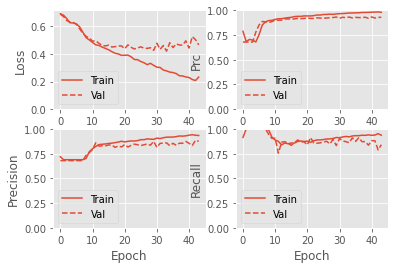

In [106]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(CDR_history)

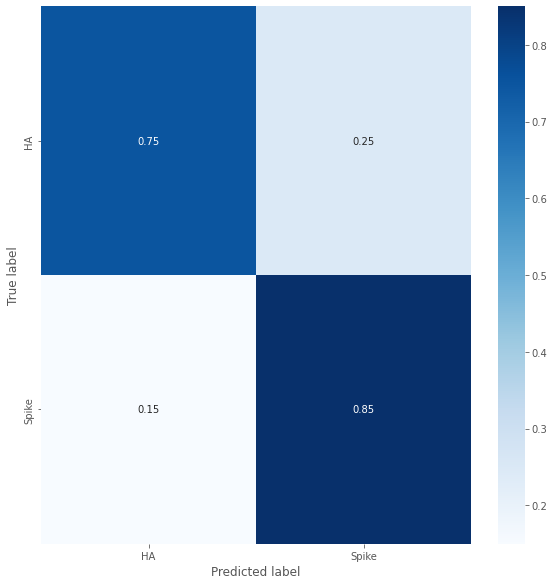

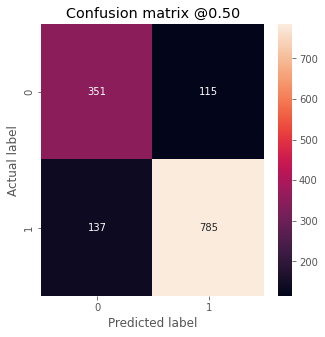

In [108]:
y_pred=CDR_model.predict([test_x1,test_x2,test_x3,test_x4,test_x5,test_x6])

con_mat = confusion_matrix(y_test, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_cm(labels=y_test, predictions=y_pred)

In [109]:
data_path = 'data/Momsen_Abs.xlsx'
Momsen_df = pd.read_excel(data_path)

[Momsen_test_x1,Momsen_test_x2,Momsen_test_x3,Momsen_test_x4,Momsen_test_x5,Momsen_test_x6]=encode_six_CDR(Momsen_df)
Momsen_test_y=le.transform(Momsen_df['Protein + Epitope'])
print(Momsen_test_x1.shape)


(81, 30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 92ms/step - loss: 0.2364 - tp: 71.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 10.0000 - accuracy: 0.8765 - precision: 1.0000 - recall: 0.8765 - auc: 0.0000e+00 - prc: 1.0000


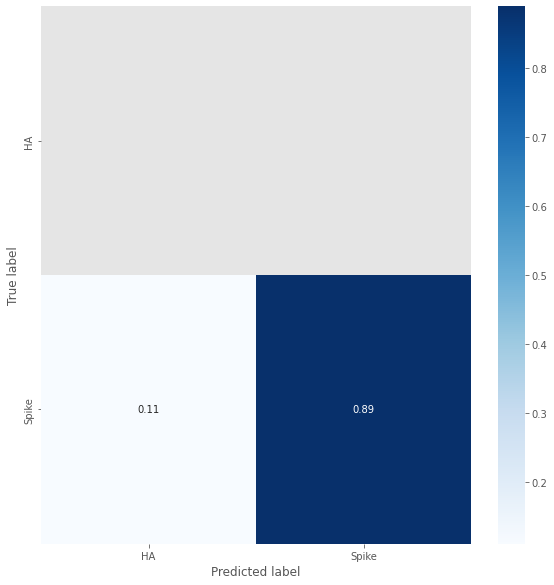

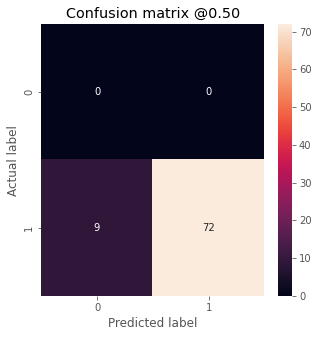

In [111]:
y_pred=CDR_model.predict([Momsen_test_x1,Momsen_test_x2,Momsen_test_x3,Momsen_test_x4,Momsen_test_x5,Momsen_test_x6])

con_mat = confusion_matrix(Momsen_test_y, y_pred >0.5)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = le.classes_, 
                     columns = le.classes_)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plot_cm(labels=Momsen_test_y, predictions=y_pred)

Momsen_test_score = CDR_model.evaluate([Momsen_test_x1,Momsen_test_x2,Momsen_test_x3,Momsen_test_x4,Momsen_test_x5,Momsen_test_x6], Momsen_test_y, batch_size=256, verbose=1)

Evaluate results
--------------------

In [91]:
# Utility function: Display model score(Loss & Accuracy and so on) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[5])
  print('Train Precision: ', train_score[6])
  print('Train Recall: ', train_score[7])
  print('Train AUC: ', train_score[8])
  print('Train PRC: ', train_score[9])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[5])
  print('Val Precision: ', val_score[6])
  print('Val Recall: ', val_score[7])
  print('Val AUC: ', val_score[8])
  print('Val PRC: ', val_score[9])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[5])
  print('Test Precision: ', test_score[6])
  print('Test Recall: ', test_score[7])
  print('Test AUC: ', test_score[8])
  print('Test PRC: ', test_score[9])

In [92]:
display_model_score(CDR_model,
    [[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train],
    [[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val],
    [[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6], y_test],
    256)


18/18 [==============================] - 2s 97ms/step - loss: 0.3039 - tp: 2664.0000 - fp: 169.0000 - tn: 1213.0000 - fn: 395.0000 - accuracy: 0.8730 - precision: 0.9403 - recall: 0.8709 - auc: 0.9400 - prc: 0.9711
Train loss:  0.303890198469162
Train accuracy:  0.8730015754699707
Train Precision:  0.9403459429740906
Train Recall:  0.8708728551864624
Train AUC:  0.9399790167808533
Train PRC:  0.9710932970046997
----------------------------------------------------------------------
5/5 [==============================] - 1s 95ms/step - loss: 0.4549 - tp: 608.0000 - fp: 90.0000 - tn: 266.0000 - fn: 147.0000 - accuracy: 0.7867 - precision: 0.8711 - recall: 0.8053 - auc: 0.8584 - prc: 0.9218
Val loss:  0.4549166262149811
Val accuracy:  0.786678671836853
Val Precision:  0.8710601925849915
Val Recall:  0.8052980303764343
Val AUC:  0.8584381341934204
Val PRC:  0.9218359589576721
----------------------------------------------------------------------
6/6 [==============================] - 1s 93m

In [ ]:
# CDRH3_only_model = keras.models.load_model('./CDRH3_only_model')
# CDRL3_only_model = keras.models.load_model('./CDRL3_only_model')
# CDRHL3_only_model = keras.models.load_model('./CDRHL3_only_model')
# CDRH12_only_model = keras.models.load_model('./CDRH12_only_model')
# CDRL12_only_model = keras.models.load_model('./CDRL12_only_model')
# CDRH123_only_model = keras.models.load_model('./CDRH123_only_model')
# CDRL123_only_model = keras.models.load_model('./CDRL123_only_model')
# CDR_model = keras.models.load_model('./CDR_model')

In [93]:
def eval_model(model, train, val, test, batch_size):
  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  return [train_score,val_score,test_score]


In [94]:
cdrh3_ls = eval_model(CDRH3_model,
    [train_x5, y_train],
    [val_x5, y_val],
    [test_x5, y_test],
    256)
cdrh3_df = pd.DataFrame(cdrh3_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 


6/6 [==============================] - 0s 29ms/step - loss: 0.5673 - tp: 766.0000 - fp: 229.0000 - tn: 237.0000 - fn: 156.0000 - accuracy: 0.7226 - precision: 0.7698 - recall: 0.8308 - auc: 0.7399 - prc: 0.8292


In [95]:
cdrl3_ls = eval_model(CDRL3_model,
    [train_x6, y_train],
    [val_x6, y_val],
    [test_x6, y_test],
    256)
cdrl3_df = pd.DataFrame(cdrl3_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 


6/6 [==============================] - 0s 29ms/step - loss: 0.5769 - tp: 796.0000 - fp: 287.0000 - tn: 179.0000 - fn: 126.0000 - accuracy: 0.7024 - precision: 0.7350 - recall: 0.8633 - auc: 0.7162 - prc: 0.8177


In [96]:
cdrhl3_ls = eval_model(CDRHL3_model,
    [[train_x5,train_x6], y_train],
    [[val_x5,val_x6], y_val],
    [[test_x5,test_x6], y_test],
    256)
cdrhl3_df = pd.DataFrame(cdrhl3_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

6/6 [==============================] - 0s 43ms/step - loss: 0.5454 - tp: 795.0000 - fp: 212.0000 - tn: 254.0000 - fn: 127.0000 - accuracy: 0.7558 - precision: 0.7895 - recall: 0.8623 - auc: 0.7862 - prc: 0.8681


In [97]:
cdrh12_ls = eval_model(CDRH12_model,
    [[train_x1,train_x3], y_train],
    [[val_x1,val_x3], y_val],
    [[test_x1,test_x3], y_test],
    256)
cdrh12_df = pd.DataFrame(cdrh12_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

6/6 [==============================] - 0s 44ms/step - loss: 0.4768 - tp: 786.0000 - fp: 173.0000 - tn: 293.0000 - fn: 136.0000 - accuracy: 0.7774 - precision: 0.8196 - recall: 0.8525 - auc: 0.8339 - prc: 0.9015


In [98]:
cdrl12_ls = eval_model(CDRL12_model,
    [[train_x2,train_x4], y_train],
    [[val_x2,val_x4], y_val],
    [[test_x2,test_x4], y_test],
    256)
cdrl12_df = pd.DataFrame(cdrl12_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 
print(cdrl12_df)

6/6 [==============================] - 0s 44ms/step - loss: 0.5423 - tp: 774.0000 - fp: 222.0000 - tn: 244.0000 - fn: 148.0000 - accuracy: 0.7334 - precision: 0.7771 - recall: 0.8395 - auc: 0.7637 - prc: 0.8433
               loss      tp     fp  ...    recall       AUC       PRC
train set  0.477189  2697.0  576.0  ...  0.881661  0.806844  0.881814
val set    0.532613   650.0  177.0  ...  0.860927  0.760637  0.854994
test set   0.542295   774.0  222.0  ...  0.839479  0.763681  0.843283

[3 rows x 10 columns]


In [99]:
cdrh123_ls = eval_model(CDRH123_model,
    [[train_x1,train_x3,train_x5], y_train],
    [[val_x1,val_x3,val_x5], y_val],
    [[test_x1,test_x3,test_x5], y_test],
    256)
cdrh123_df = pd.DataFrame(cdrh123_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

6/6 [==============================] - 0s 55ms/step - loss: 0.4655 - tp: 804.0000 - fp: 152.0000 - tn: 314.0000 - fn: 118.0000 - accuracy: 0.8055 - precision: 0.8410 - recall: 0.8720 - auc: 0.8568 - prc: 0.9136


In [100]:
cdrl123_ls = eval_model(CDRL123_model,
    [[train_x2,train_x4,train_x6], y_train],
    [[val_x2,val_x4,val_x6], y_val],
    [[test_x2,test_x4,test_x6], y_test],
    256)
cdrl123_df = pd.DataFrame(cdrl123_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

6/6 [==============================] - 0s 53ms/step - loss: 0.5325 - tp: 766.0000 - fp: 226.0000 - tn: 240.0000 - fn: 156.0000 - accuracy: 0.7248 - precision: 0.7722 - recall: 0.8308 - auc: 0.7726 - prc: 0.8646


In [112]:
cdr_ls = eval_model(CDR_model,
    [[train_x1,train_x2,train_x3,train_x4,train_x5,train_x6], y_train],
    [[val_x1,val_x2,val_x3,val_x4,val_x5,val_x6], y_val],
    [[test_x1,test_x2,test_x3,test_x4,test_x5,test_x6], y_test],
    256)
cdr_df = pd.DataFrame(cdr_ls, columns =['loss','tp', 'fp' , 'tn','fn', 'accuracy','precision', 'recall','AUC','PRC'], index=['train set','val set','test set'],dtype = float) 

6/6 [==============================] - 1s 90ms/step - loss: 0.4574 - tp: 778.0000 - fp: 124.0000 - tn: 342.0000 - fn: 144.0000 - accuracy: 0.8069 - precision: 0.8625 - recall: 0.8438 - auc: 0.8652 - prc: 0.9195


In [113]:
df=pd.concat([cdrh3_df,cdrl3_df,cdrhl3_df,cdrh12_df,cdrh123_df,cdrl12_df,cdrl123_df,cdr_df])
print(df)
df.to_csv('result/diff_model_evaluation.csv')

               loss      tp     fp  ...    recall       AUC       PRC
train set  0.438176  2694.0  485.0  ...  0.880680  0.849698  0.906368
val set    0.550107   633.0  180.0  ...  0.838411  0.746897  0.834991
test set   0.567321   766.0  229.0  ...  0.830803  0.739921  0.829213
train set  0.473828  2739.0  676.0  ...  0.895391  0.820545  0.899208
val set    0.562441   652.0  212.0  ...  0.863576  0.723337  0.825714
test set   0.576905   796.0  287.0  ...  0.863341  0.716238  0.817702
train set  0.336038  2835.0  382.0  ...  0.926773  0.916041  0.953352
val set    0.538598   634.0  166.0  ...  0.839735  0.785564  0.876136
test set   0.545438   795.0  212.0  ...  0.862256  0.786240  0.868087
train set  0.368835  2762.0  357.0  ...  0.902909  0.894756  0.942733
val set    0.454869   659.0  138.0  ...  0.872848  0.843050  0.910104
test set   0.476838   786.0  173.0  ...  0.852495  0.833871  0.901499
train set  0.277342  2853.0  265.0  ...  0.932658  0.939959  0.967856
val set    0.449645 

# save model

In [114]:
# saving model weights.
CDRH3_model.save('./CDRH3_only_model')
# load model
# CDRH3_model = keras.models.load_model('./CDRH3_only_model')

INFO:tensorflow:Assets written to: ./CDRH3_only_model/assets


INFO:tensorflow:Assets written to: ./CDRH3_only_model/assets


In [115]:
# saving model weights.
CDRL3_model.save('./CDRL3_only_model')
# load model
# CDRL3_model = keras.models.load_model('./CDRL3_only_model')

INFO:tensorflow:Assets written to: ./CDRL3_only_model/assets


INFO:tensorflow:Assets written to: ./CDRL3_only_model/assets


In [116]:
# saving model weights.
CDRHL3_model.save('./CDRHL3_only_model')
# load model
# model = keras.models.load_model('./CDRHL3_only_model')

INFO:tensorflow:Assets written to: ./CDRHL3_only_model/assets


INFO:tensorflow:Assets written to: ./CDRHL3_only_model/assets


In [117]:
# saving model weights.
CDRH12_model.save('./CDRH12_only_model')
# load model
# model = keras.models.load_model('./CDRH12_only_model')

INFO:tensorflow:Assets written to: ./CDRH12_only_model/assets


INFO:tensorflow:Assets written to: ./CDRH12_only_model/assets


In [118]:
# saving model weights.
CDRL12_model.save('./CDRL12_only_model')
# load model
# model = keras.models.load_model('./CDRL12_only_model')

INFO:tensorflow:Assets written to: ./CDRL12_only_model/assets


INFO:tensorflow:Assets written to: ./CDRL12_only_model/assets


In [119]:
# saving model weights.
CDRH123_model.save('./CDRH123_only_model')
# load model
# model = keras.models.load_model('./CDRH123_only_model')

INFO:tensorflow:Assets written to: ./CDRH123_only_model/assets


INFO:tensorflow:Assets written to: ./CDRH123_only_model/assets


In [120]:
# saving model weights.
CDRL123_model.save('./CDRL123_only_model')
# load model
# model = keras.models.load_model('./CDRL123_only_model')

INFO:tensorflow:Assets written to: ./CDRL123_only_model/assets


INFO:tensorflow:Assets written to: ./CDRL123_only_model/assets


In [121]:
# saving model weights.
CDR_model.save('./CDR_model')
# load model
# model = keras.models.load_model('./CDR_model')

INFO:tensorflow:Assets written to: ./CDR_model/assets


INFO:tensorflow:Assets written to: ./CDR_model/assets
